In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from timeit import default_timer as timer

# Preprocessing

In [22]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [23]:
df.sample(10)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
686578,686578,0.050976,0.406980,1278.10,0.019941,0.261320,6.59020,1893.700,13952.0,2.721800e+14,...,-2.6584,1.2864,-0.029136,3.10240,86064.00,1.1617,-9.616100e+14,283.130,0.363240,1
862723,862723,0.091338,0.189100,-144.92,0.002897,-0.003861,-3.74590,1079.000,771810.0,7.217000e+15,...,-14.8960,1.0383,84.091000,1.87110,453.33,1.3991,3.564800e+15,3163.900,0.091856,0
683482,683482,0.081469,0.500420,2993.70,0.083879,0.282050,-0.54030,523.420,508860.0,2.010600e+15,...,-9.2947,2.5791,1.910700,11.02900,27196.00,1.2846,5.429200e+15,1780.500,0.164480,0
945230,945230,0.099761,0.448960,1353.30,0.565020,0.467830,-2.04800,2613.900,171310.0,4.131800e+15,...,-5.2869,3.7644,-0.752440,2.02470,154490.00,1.1593,2.387200e+13,50.881,1.107000,0
800257,800257,0.152400,-0.001378,441.49,0.135360,0.000365,1.04780,488.150,275980.0,1.327900e+15,...,-46.8490,3.4471,176.290000,19.89600,-657.27,1.1570,3.016400e+15,10423.000,0.928840,1
832055,832055,0.079013,0.326040,3414.00,0.030661,0.330920,0.71345,-19.327,241040.0,4.702800e+15,...,-9.0473,3.7867,12.951000,-7.63340,52651.00,1.1902,2.019900e+17,1023.300,0.328470,1
264078,264078,0.087827,0.444740,-324.86,0.217670,0.262550,0.13383,2328.700,NaN,2.356600e+15,...,-1.3587,1.4269,156.490000,-10.94600,12802.00,1.4336,-1.241700e+14,263.580,0.524500,1
721742,721742,0.098982,-0.003790,9316.50,0.390410,0.002430,1.40330,803.720,30921.0,5.346300e+15,...,-11.6340,2.5201,1.095700,-8.48610,NaN,1.2708,-1.905200e+14,9177.500,0.716060,1
707209,707209,0.098167,NaN,1299.00,0.357770,0.209250,1.22400,400.740,65493.0,6.055200e+14,...,-2.4154,3.9723,6.418200,3.06970,150780.00,1.2074,2.234600e+17,10329.000,0.735810,0
928855,928855,0.056132,0.447390,608.00,0.164950,0.385360,6.62250,113.200,30909.0,9.247900e+14,...,-2.6197,1.6397,0.417300,0.38621,327500.00,1.1519,2.672200e+15,6357.000,1.002900,1


In [24]:
df = df.drop(columns='id')
df_test = df_test.drop(columns='id')

## Impute missing values

In [25]:
df.isnull().sum()

f1       15247
f2       15190
f3       15491
f4       15560
f5       15405
         ...  
f115     15559
f116     15589
f117     15407
f118     15212
claim        0
Length: 119, dtype: int64

In [26]:
df = df.fillna(df.median())
df_test = df_test.fillna(df.median())

In [27]:
df.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

## Remove outliers

In [28]:
from scipy import stats

z = np.abs(stats.zscore(df))
out = np.where(z>5)
out[0].shape

(27948,)

In [29]:
df.shape

(957919, 119)

In [31]:
df = df.drop(index=out[0], axis=0)
df.shape

(930360, 119)

## Check balance

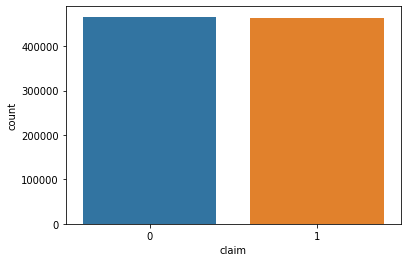

In [32]:
sns.countplot(data=df, x='claim');
# balanced

## Get X,y and split into train and val sets

In [52]:
frac = 0.1
X = df.drop(columns='claim').sample(frac=frac, random_state=42)
y = df['claim'].sample(frac=frac, random_state=42)

X_test = df_test.copy()

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((74428, 118), (18608, 118))

## Feature Selection

In [34]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(n_estimators=10, n_jobs=10) 
rfe = RFE(estimator, n_features_to_select=20)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_val_rfe = rfe.fit_transform(X_val, y_val)

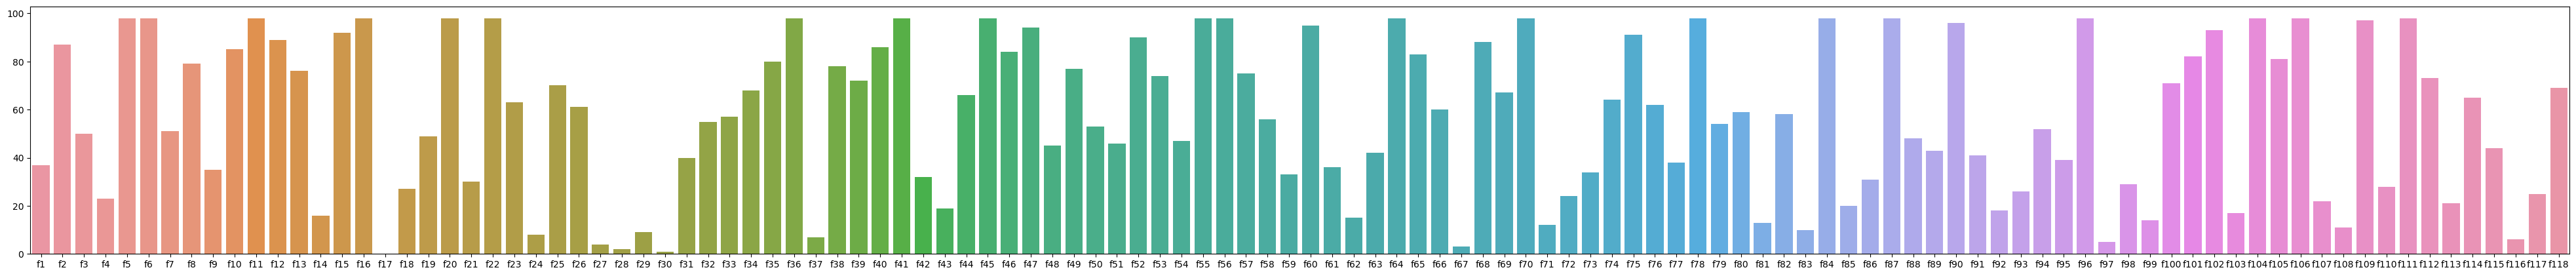

In [37]:
plt.figure(figsize=(50,5), dpi=100)
sns.barplot(x=X_train.columns, y=max(rfe.ranking_)-rfe.ranking_);

In [39]:
rfe_features = X_train.columns[rfe.support_]
rfe_features

Index(['f5', 'f6', 'f11', 'f16', 'f20', 'f22', 'f36', 'f41', 'f45', 'f55',
       'f56', 'f64', 'f70', 'f78', 'f84', 'f87', 'f96', 'f104', 'f106',
       'f111'],
      dtype='object')

## ML Models

In [60]:
frac = 1
X = df[rfe_features].sample(frac=frac, random_state=42)
y = df['claim'].sample(frac=frac, random_state=42)

X_test = df_test[rfe_features].copy().sample(frac=frac, random_state=42)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((744288, 20), (186072, 20), (493474, 20))

### Scaling

In [61]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

In [62]:
def fit_ML_model(modelName, model, acc=pd.DataFrame([], index=['Train Accuracy','Test Accuracy','Time (s)'])):

    from sklearn.metrics import accuracy_score
    
    start = timer()
    model.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_val = accuracy_score(y_val, model.predict(X_val))
    end = timer()

    acc[modelName] = [acc_train, acc_val, end-start]

    return model, acc

### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

gb, acc = fit_ML_model('LogReg', LogisticRegression())
acc

,LogReg
Train Accuracy,0.512042
Test Accuracy,0.510496
Time (s),0.859664


### XGBoost

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# start = timer()
# xgb = XGBClassifier(n_estimators=1000, learning_rate=0.1, 
#                     tree_method='exact', use_label_encoder=False, n_jobs=16)
# xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='logloss', 
#         early_stopping_rounds=10, verbose=1)

# acc_train = accuracy_score(y_train, xgb.predict(X_train))
# acc_val = accuracy_score(y_val, xgb.predict(X_val))
# end = timer()

start = timer()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

xgb = XGBClassifier(verbosity=1, tree_method='exact', use_label_encoder=False)
grid_search = GridSearchCV(xgb, param_grid, scoring='neg_log_loss', n_jobs=-1, cv=10)
grid_result = grid_search.fit(X, y, eval_metric='logloss')

acc_train = accuracy_score(y_train, grid_result.predict(X_train))
acc_val = accuracy_score(y_val, grid_result.predict(X_val))
end = timer()

acc['XGBoost'] = [acc_train, acc_val, end-start]
acc

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras

nodes = 256
n_hidden = 5
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for i in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))
#     ann.add(keras.layers.Dense(nodes//(2**(i+1)), activation=activation))

ann.add(keras.layers.Dense(2, activation="softmax"))

ann.summary()

In [ ]:
epochs = 1000
batch_size = 10000

# lr =1e-2 # epcohs 0 --> 50 
lr =5e-3 # epochs 50 --> 100 

optimizer = tf.keras.optimizers.SGD(learning_rate=lr) 
ann.compile(loss='binary_crossentropy', optimizer=optimizer)

start = timer()
history = ann.fit(X_train, pd.get_dummies(y_train), validation_data=(X_val, pd.get_dummies(y_val)), 
                    epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size)
end = timer()

In [ ]:
acc_train = accuracy_score(y_train, ann.predict(X_train, batch_size=batch_size).argmax(axis=1))
acc_val = accuracy_score(y_val, ann.predict(X_val, batch_size=batch_size).argmax(axis=1))
end = timer()

acc['NN'] = [acc_train, acc_val, end-start]
acc